In [33]:
from transformers import pipeline, AutoTokenizer
from datasets import Dataset

In [3]:
twitter = "cardiffnlp/twitter-roberta-base-sentiment-latest"
financial = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
device = "cuda"
truncate= True

classifierConfig = dict(
    task = "text-classification",
    model = twitter,
    device = device,
    truncation = truncate,
    max_length = 512,
    return_all_scores = True
)

classifierConfig2 = dict(
    task = "text-classification",
    model = financial,
    device = device,
    truncation = truncate,
    max_length = 512,
    return_all_scores = True
)

summarizerConfig = dict(
    task = "summarization",
    model = "facebook/bart-large-cnn",
    device = device,
    do_sample = True,
    # max_length = 512,
    truncation = truncate,
    num_beams = 2,
    num_return_sequences = 1
)

classifier = pipeline(**classifierConfig)
finClassifier = pipeline(**classifierConfig2)
tokenizerClassifier =AutoTokenizer.from_pretrained(twitter, device="cuda")
summarizer = pipeline(**summarizerConfig)

c:\Users\zizh3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a mode

In [11]:
import requests
import json
import datetime


with open("credential", "r") as f:
    jsonStr = f.read()
    creds = json.loads(jsonStr)


def fetchNews(start:datetime.datetime, end:datetime.datetime, symbols:str, limit:int=20, include_content:bool=True, exclude_contentless:bool=True):
    newsList = []
    startStr = start.strftime("%Y-%m-%dT%H:%M:%SZ")
    endStr = end.strftime("%Y-%m-%dT%H:%M:%SZ")
    url = f"https://data.alpaca.markets/v1beta1/news?start={startStr}&end={endStr}&sort=desc&symbols={symbols}&limit={limit}&include_content={include_content}&exclude_contentless={exclude_contentless}"
    headers = {"accept": "application/json", "APCA-API-KEY-ID": creds["alpacaPaper"][0], "APCA-API-SECRET-KEY": creds["alpacaPaper"][1]}

    resp = requests.get(url, headers=headers)
    if resp.status_code != 200:
        raise Exception(f"Failed to fetch news: {resp.status_code} {resp.text}")
    data = resp.json()
    news = data.get("news", [])
    newsList.extend(news)
    next_page_token = data.get("next_page_token", None)
    while next_page_token:
        url = f"https://data.alpaca.markets/v1beta1/news?start={startStr}&end={endStr}&sort=desc&symbols={symbols}&limit={limit}&include_content={include_content}&exclude_contentless={exclude_contentless}&page_token={next_page_token}"
        resp = requests.get(url, headers=headers)
        if resp.status_code != 200:
            raise Exception(f"Failed to fetch news: {resp.status_code} {resp.text}")
        data = resp.json()
        news = data.get("news", [])
        newsList.extend(news)
        next_page_token = data.get("next_page_token", None)
    return newsList

import regex as re
import numpy as np  

htmlElement = re.compile(r"<.*?>")
def preprocessTexts(text):
    # remove html elements
    processed = re.sub(htmlElement, "", text)
    # remove special chars
    processed = re.sub(r"&amp;", "&", processed)
    processed = re.sub(r"\s+|&#[0-9]+;|&nbsp;", " ", processed)
    return processed

labelArr = ["negative", "neutral", "positive"]
def getLabel(score):
    scores = np.array([score[0]["score"], score[1]["score"], score[2]["score"]])
    return labelArr[np.argmax(scores)]


news = fetchNews(datetime.datetime.now()-datetime.timedelta(days=3), datetime.datetime.now(), "NVDA", 50, True, True)  
len(news)

54

In [29]:
max([len(n["content"]) for n in news])

10862

In [31]:
news[0]["content"]

'<p>The stock of <strong>Samsung Electronics Co</strong> (OTC:<a class="ticker" href="https://www.benzinga.com/stock/SSNLF#OTC">SSNLF</a>) experienced a significant surge on Wednesday following reports of interest from <strong>NVIDIA Corp</strong> (NASDAQ:<a class="ticker" href="https://www.benzinga.com/stock/NVDA#NASDAQ">NVDA</a>) in its next-generation high-bandwidth memory (HBM) chips.</p>\n\n\n\n<p><strong>What Happened</strong>: Samsung Electronics&#8217; shares rose by more than 5% after Nvidia&#8217;s CEO, <strong>Jensen Huang</strong>, hinted at the possibility of using Samsung&#8217;s new HBM chips for its graphics processing units. Huang praised Samsung&#8217;s HBM memory, calling it &#8220;very complicated&#8221; and &#8220;very good,&#8221; <a href="https://www.kedglobal.com/korean-chipmakers/newsView/ked202403200013">reported</a> Korea Economic Daily Wednesday.</p>\n\n\n\n<p><strong><br></strong>According to the report, Huang said, "HBM memory is very complicated, and the 

In [14]:
from tokenizers.pre_tokenizers import Whitespace

preTokenizer = Whitespace()
pretokens = [preTokenizer.pre_tokenize_str(preprocessTexts(n["content"])) for n in news]
lengthyIndex = [i for i, p in enumerate(pretokens) if len(p) > 512]

def splitAndSummarize(text:str, pretoken:list[tuple[int,int]]):
    """
    greedy split the text into 512 tokens and summarize each split
    """
    count = len(pretoken)
    index = 0
    lastSplitIndex = 0
    prevIndex = index
    splits = []
    while index < count:
        if index - lastSplitIndex > 512:
            start = pretoken[lastSplitIndex][1][0]
            end = pretoken[prevIndex][1][0]
            splits.append(text[start:end])
            lastSplitIndex = prevIndex
        prevIndex = index
        index += 1
    return splits

splitAndSummarize(preprocessTexts(news[0]["content"]), pretokens[0])

['The stock of Samsung Electronics Co (OTC:SSNLF) experienced a significant surge on Wednesday following reports of interest from NVIDIA Corp (NASDAQ:NVDA) in its next-generation high-bandwidth memory (HBM) chips. What Happened: Samsung Electronics  shares rose by more than 5% after Nvidia s CEO, Jensen Huang, hinted at the possibility of using Samsung s new HBM chips for its graphics processing units. Huang praised Samsung s HBM memory, calling it  very complicated  and  very good,  reported Korea Economic Daily Wednesday. According to the report, Huang said, "HBM memory is very complicated, and the value added is very high. We are spending a lot of money on HBM." Despite the positive remarks, the qualification process does not guarantee purchase. This news comes after Samsung s competitor, SK Hynix, announced that it would be supplying its HBM chips to Nvidia, which led to a drop in SK Hynix s stock by 3.56% on Wednesday. HBM, a high-value and high-performance memory chip, comprises 

In [15]:
text = preprocessTexts(news[0]["content"])

In [26]:
from openai import OpenAI

client = OpenAI(api_key=creds["openai"][0])

response = client.chat.completions.create(
  model="gpt-3.5-turbo-0125",
  messages=[
    {"role": "system", "content": "You are a financial analyst."},
    {"role": "user", "content": f"Does the following news have impact on the stock price of NVDA? Limit your response within 256 words. \n{text}"},
  ]
)

response

ChatCompletion(id='chatcmpl-94rrSwteh7eKGezV2pm4OEmiWsKgy', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="The news of NVIDIA's interest in Samsung Electronics' new HBM chips could have a potential impact on the stock price of NVDA. NVIDIA's CEO, Jensen Huang, praising Samsung's HBM memory and expressing interest in using it for their GPUs signifies a positive development for Samsung and a potential strategic partnership between the two companies. This could lead to increased demand for Samsung's HBM chips and potentially boost Samsung's stock price.\n\nHowever, it is important to note that the qualification process mentioned in the news does not guarantee a purchase by NVIDIA, so the actual impact on NVDA's stock price may be uncertain until a formal agreement is reached between the two companies.\n\nThe drop in the stock price of SK Hynix, Samsung's competitor, following the news of NVIDIA's interest in HBM chips could also indica

In [27]:
response.choices[0].message.content

"The news of NVIDIA's interest in Samsung Electronics' new HBM chips could have a potential impact on the stock price of NVDA. NVIDIA's CEO, Jensen Huang, praising Samsung's HBM memory and expressing interest in using it for their GPUs signifies a positive development for Samsung and a potential strategic partnership between the two companies. This could lead to increased demand for Samsung's HBM chips and potentially boost Samsung's stock price.\n\nHowever, it is important to note that the qualification process mentioned in the news does not guarantee a purchase by NVIDIA, so the actual impact on NVDA's stock price may be uncertain until a formal agreement is reached between the two companies.\n\nThe drop in the stock price of SK Hynix, Samsung's competitor, following the news of NVIDIA's interest in HBM chips could also indicate a shift in market dynamics favoring Samsung, which may positively impact NVDA's stock price as well.\n\nOverall, while the news suggests a positive developme

In [16]:
summarizer(text)

[{'summary_text': 'Samsung Electronics shares rose by more than 5% on Wednesday after reports of interest from NVIDIA Corp. Nvidia CEO, Jensen Huang, hinted at the possibility of using Samsung s new HBM chips for its graphics processing units. HBM, a high-value and high-performance memory chip, comprises vertically interconnected multiple DRAM chips. This news comes after Samsung s competitor, SK Hynix, announced that it would be supplying its HBM Chips to Nvidia.'}]

In [23]:
text2 ="The stock of Samsung Electronics Co experienced a surge after reports of interest from NVIDIA Corp in its next-generation high-bandwidth memory chips. NVIDIA's CEO praised Samsung's HBM chips, hinting at the possibility of using them for its graphics processing units. This news comes after SK Hynix, Samsung's competitor, announced supplying its HBM chips to Nvidia, leading to a drop in SK Hynix's stock. HBM chips enhance data processing speed and reduce power consumption, making them crucial for AI technologies like Nvidia's GPUs. Nvidia's interest in Samsung's chips reflects the significant growth and transformation in the chip industry, particularly in AI computing. Companies like Synopsys play a crucial role in creating chips for advanced AI technology, underscoring the importance of chip manufacturers like Samsung and SK Hynix."

finClassifier(text2)

[[{'label': 'negative', 'score': 0.00034922242048196495},
  {'label': 'neutral', 'score': 9.056922135641798e-05},
  {'label': 'positive', 'score': 0.9995601773262024}]]

In [ ]:
contentDataset = Dataset.from_dict(dict(
    inputs = [preprocessTexts(n["content"]) for n in news] 
))

summaryDataset = Dataset.from_dict(dict(
    inputs = [preprocessTexts(n["summary"]) for n in news]
))

arrContentEmoScore = classifier(contentDataset["inputs"])
arrContentEmoScore2 = finClassifier(contentDataset["inputs"])
arrSummaryEmoScore = classifier(summaryDataset["inputs"])
arrSummaries = summarizer(contentDataset["inputs"])

modelSummaryDataset = Dataset.from_dict(dict(
    inputs = [s["summary_text"] for s in arrSummaries]
))
arrModelSummaryEmoScore = classifier(modelSummaryDataset["inputs"])

processedNews = [{
    "id": n["id"],
    "time": n["created_at"],
    "source": n["source"],
    "symbols": ",".join(n["symbols"]),
    "relative_weight": 1/len(n["symbols"]),
    "title": n["headline"],
    "content": preprocessTexts(n["content"]),
    "summary":preprocessTexts(n["summary"]) if len(n["summary"].strip()) > 0 else None,
    "modelSummary": summ["summary_text"],
    "label-summ": getLabel(summEmo),
    "negative-summ": summEmo[0]["score"],
    "neutral-summ": summEmo[1]["score"],
    "positive-summ": summEmo[2]["score"],

    "label-content": getLabel(contentEmo),
    "negative-content": contentEmo[0]["score"],
    "neutral-content": contentEmo[1]["score"],
    "positive-content": contentEmo[2]["score"],

    "label-content-2": getLabel(contentEmo2),
    "negative-content-2": contentEmo2[0]["score"],
    "neutral-content-2": contentEmo2[1]["score"],
    "positive-content-2": contentEmo2[2]["score"],

    "label-model-summ": getLabel(mdSummEmo),
    "negative-model-summ": mdSummEmo[0]["score"],
    "neutral-model-summ": mdSummEmo[1]["score"],
    "positive-model-summ": mdSummEmo[2]["score"],
} for n, summ, summEmo, contentEmo, mdSummEmo, contentEmo2 in zip(news, arrSummaries, arrSummaryEmoScore, arrContentEmoScore, arrModelSummaryEmoScore, arrContentEmoScore2)]


# processedNews = [{
#     "id": n["id"],
#     "time": n["created_at"],
#     "source": n["source"],
#     "symbols": ",".join(n["symbols"]),
#     "relative_weight": 1/len(n["symbols"]),
#     "title": n["headline"],
#     "content": preprocessTexts(n["content"]),
#     "summary":preprocessTexts(n["summary"]) if len(n["summary"].strip()) > 0 else None,
#     "modelSummary": summ["summary_text"],
#     "label": getLabel(summEmo),
#     "negative": summEmo[0]["score"],
#     "neutral": summEmo[1]["score"],
#     "positive": summEmo[2]["score"],
# } for n, summ, summEmo in zip(news, arrSummaries, arrSummaryEmoScore)]

Text(0.5, 1.0, 'content length')

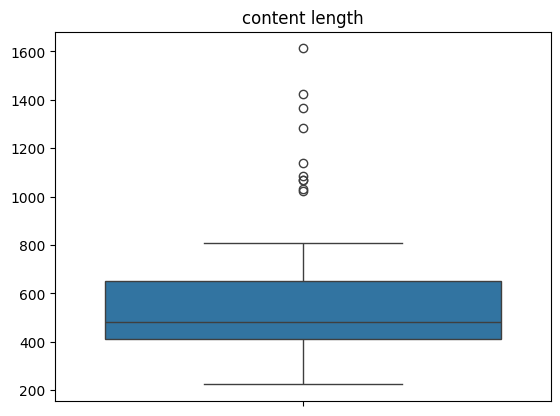

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


tokenLength = [len(n["content"].split()) for n in processedNews]
sns.boxplot(tokenLength).set_title("content length")

In [8]:
df = pd.DataFrame(processedNews)
df.head()

,id,time,source,symbols,relative_weight,title,content,summary,modelSummary,label-summ,...,neutral-content,positive-content,label-content-2,negative-content-2,neutral-content-2,positive-content-2,label-model-summ,negative-model-summ,neutral-model-summ,positive-model-summ
0,37763876,2024-03-16T01:46:15Z,benzinga,"AAPL,NVDA,TSLA",0.333333,'Forced Sale Or Ban' On TikTok Will Impact App...,Deepwater Asset Management s managing partner ...,"Gene Munster, managing partner at Deepwater As...",Gene Munster has raised concerns about potenti...,neutral,...,0.812728,0.028164,positive,0.001623,0.009011,0.989366,neutral,0.263879,0.702982,0.033139
1,37760781,2024-03-15T20:49:41Z,benzinga,"NVDA,SMH,SPY,TSM",0.250000,Reddit's WallStreetBets Top Trending Stocks Th...,Retail investors remained enthusiastic on semi...,Retail investors remained enthusiastic on semi...,Nvidia Corporation (NASDAQ:NVDA) was the most ...,positive,...,0.303573,0.692213,positive,0.000195,0.000663,0.999142,positive,0.002871,0.412117,0.585013
2,37760456,2024-03-15T20:39:37Z,benzinga,"AMD,BA,BTCUSD,CCL,MSFT,NVDA,RCL",0.142857,Inflation Rattles Markets Ahead Of Fed Meeting...,Inflation reports unveiled in the week precedi...,Inflation reports unveiled in the week precedi...,Inflation reports unveiled in the week precedi...,negative,...,0.659620,0.039068,negative,0.837385,0.000911,0.161703,negative,0.642624,0.346190,0.011186
3,37758057,2024-03-15T19:32:22Z,benzinga,"AAPL,AVGO,JEPI,META,MSFT,NVDA,QQQI,QYLD,SPYI,T...",0.090909,QQQI: The Undiscovered Nasdaq-100 Covered Call...,"A few months ago, I analyzed the total perform...","A few months ago, I analyzed the total perform...",The Nasdaq-100 Index delivered +54.9% returns ...,neutral,...,0.453163,0.538203,positive,0.000208,0.000613,0.999179,positive,0.002859,0.031906,0.965235
4,37757767,2024-03-15T19:14:18Z,benzinga,"AMD,AMZN,AOTG,ARM,BABA,INTC,NVDA,SOXQ",0.125000,AMD's Success in Cloud Expansion - This Analys...,KeyBanc analyst John Vinh maintained an Overwe...,KeyBanc analyst maintains Overweight rating on...,KeyBanc maintains an Overweight rating on Adva...,positive,...,0.557365,0.433582,positive,0.000886,0.000084,0.999031,positive,0.005141,0.313331,0.681528


<Axes: >

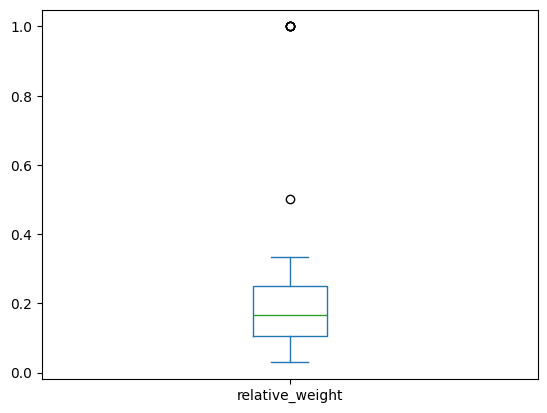

In [9]:
df.relative_weight.plot.box()

In [10]:
import datetime
df.to_csv(f"news-{datetime.datetime.now().timestamp()}.csv", index=False)

<Axes: >

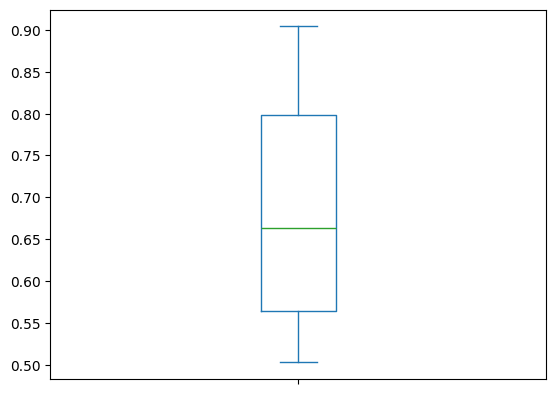

In [11]:
df[["negative-content", "neutral-content", "positive-content"]].apply(max, axis=1).plot.box()

financial classifier stats:
- overall AR = 0.48
- summs AR = 0.58
- summ-content AR = 0.63
- model-summ-content AR= 0.69
- max score dist: lower 25th quantile >= 0.95 skewed

twitter classifier stats:
- overall AR = 0.46
- summs AR = 0.58
- summ-content AR = 0.71
- model-summ-content AR= 0.60
- max score dist: 0.5~0.9 normal
- no negative prediction on content

In [12]:
ar = df.index.map(lambda i: df.loc[i, "label-summ"] == df.loc[i, "label-model-summ"] == df.loc[i, "label-content"]).to_series().mean()
summsAR = df.index.map(lambda i: df.loc[i, "label-summ"] == df.loc[i, "label-model-summ"]).to_series().mean()
summContentAr = df.index.map(lambda i: df.loc[i, "label-summ"] == df.loc[i, "label-content"]).to_series().mean()
modelSummContentAr = df.index.map(lambda i: df.loc[i, "label-model-summ"] == df.loc[i, "label-content"]).to_series().mean()
ar, summsAR, summContentAr, modelSummContentAr

(0.41304347826086957,
 0.6304347826086957,
 0.6086956521739131,
 0.5869565217391305)

Check majority class

In [13]:
df[["negative-model-summ","neutral-model-summ","positive-model-summ",]].apply(np.argmax, axis=1).value_counts(sort=False)

1    19
2    23
0     4
Name: count, dtype: int64

In [14]:
df[["negative-summ","neutral-summ","positive-summ",]].apply(np.argmax, axis=1).value_counts(sort=False)

1    22
2    21
0     3
Name: count, dtype: int64

In [15]:
df[["negative-content","neutral-content","positive-content",]].apply(np.argmax, axis=1).value_counts(sort=False)

1    30
2    16
Name: count, dtype: int64

In [16]:
df[["negative-content-2","neutral-content-2","positive-content-2",]].apply(np.argmax, axis=1).value_counts(sort=False)

2    34
0     7
1     5
Name: count, dtype: int64

Insights

- the twitter model fails to capture negative info from the content probably because it measures more of the wording sentiment rather than the effect to financial operation.